In [1]:
import nltk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset, DatasetDict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from transformers import AutoTokenizer, AutoModel
import torch
from collections import Counter
import nltk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset, DatasetDict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from transformers import AutoTokenizer, AutoModel
import torch
from collections import Counter


c:\Users\liste\miniconda3\envs\CS445Final\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_and_prepare_data():
    """
    Downloads (if necessary) and loads the Brown corpus, then splits it
    into training and test sets.
    """
    print("Step 1: Loading and preparing data...")
    try:
        from nltk.corpus import brown
    except ImportError:
        print("NLTK is not installed. Please install it with 'pip install nltk'")
        return None, None
    except LookupError:
        print("Downloading the 'brown' corpus from NLTK...")
        nltk.download('brown')
        from nltk.corpus import brown

    categories = brown.categories()
    print(f"Number of genres (classes): {len(categories)}")

    # Construct a dictionary compatible with the 'datasets' library
    data_dict = {
        "text": [" ".join(sent) for file_id in brown.fileids() for sent in brown.sents(fileids=file_id)],
        "label": [categories.index(brown.categories(fileids=file_id)[0]) for file_id in brown.fileids() for sent in brown.sents(fileids=file_id)]
    }

    full_dataset = Dataset.from_dict(data_dict)

    # Split the data: 80% train, 20% test
    final_splits = full_dataset.train_test_split(test_size=0.2, seed=42)

    print("Data loading and splitting complete.")
    print(f"Training set size: {len(final_splits['train'])}")
    print(f"Test set size: {len(final_splits['test'])}")
    
    return final_splits, categories

In [3]:
def train_tfidf_model(datasets, categories):
    """
    Trains and evaluates a Logistic Regression model using TF-IDF features.
    """
    print("\nStep 2: Training Model 1 (TF-IDF + Logistic Regression)...")

    # Use a higher n-gram size to capture more context
    vectorizer = TfidfVectorizer(
        ngram_range=(1, 2),
        stop_words='english',
        max_features=10000  # Limit feature space to prevent memory issues
    )

    # Fit on training data and transform train/test splits
    X_train = vectorizer.fit_transform(datasets['train']['text'])
    X_test = vectorizer.transform(datasets['test']['text'])

    y_train = datasets['train']['label']
    y_test = datasets['test']['label']

    print("Training the logistic regression classifier...")
    # Increase max_iter to ensure convergence
    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_train, y_train)

    print("Evaluating the model...")
    y_pred = model.predict(X_test)

    print("\n--- TF-IDF Model Results ---")
    cr = classification_report(y_test, y_pred, target_names=categories, output_dict=True)
    print(cr)
    
    cm = confusion_matrix(y_test, y_pred)
    return cm, cr


In [4]:
def get_bert_embeddings(texts, model, tokenizer, device):
    """
    Generates static BERT embeddings for a list of texts.
    We use the mean of the last hidden state as the sentence embedding.
    """
    all_embeddings = []
    # Process in batches to manage memory
    batch_size = 32
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True, max_length=512).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        
        # Mean pooling of the last hidden state
        embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        all_embeddings.append(embeddings)
    
    return np.vstack(all_embeddings)

In [5]:
def train_bert_embedding_model(datasets, categories):
    """
    Trains and evaluates a Logistic Regression model using static BERT embeddings.
    """
    print("\nStep 3: Training Model 2 (BERT Embeddings + Logistic Regression)...")

    # Setup device, tokenizer, and model
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")
    model_name = 'bert-base-uncased'
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name).to(device)

    print("Generating BERT embeddings for the dataset (this may take a while)...")
    X_train_bert = get_bert_embeddings(datasets['train']['text'], model, tokenizer, device)
    X_test_bert = get_bert_embeddings(datasets['test']['text'], model, tokenizer, device)

    y_train = datasets['train']['label']
    y_test = datasets['test']['label']

    print("Training the logistic regression classifier on BERT embeddings...")
    lr_bert_model = LogisticRegression(max_iter=1000, random_state=42)
    lr_bert_model.fit(X_train_bert, y_train)

    print("Evaluating the model...")
    y_pred_bert = lr_bert_model.predict(X_test_bert)

    print("\n--- BERT Embeddings Model Results ---")
    cr = classification_report(y_test, y_pred_bert, target_names=categories, output_dict=True)
    print(cr)

    cm = confusion_matrix(y_test, y_pred_bert)
    return cm, cr

In [6]:
def plot_confusion_matrix(cm, categories, title):
    """
    Plots a confusion matrix using seaborn's heatmap.
    """
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=categories, yticklabels=categories)
    plt.title(title)
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

Step 1: Loading and preparing data...
Number of genres (classes): 15
Data loading and splitting complete.
Training set size: 45872
Test set size: 11468

Step 2: Training Model 1 (TF-IDF + Logistic Regression)...
Training the logistic regression classifier...
Evaluating the model...

--- TF-IDF Model Results ---
{'adventure': {'precision': 0.4296951819075713, 'recall': 0.4571129707112971, 'f1-score': 0.44298023314749113, 'support': 956.0}, 'belles_lettres': {'precision': 0.40928469919469446, 'recall': 0.5925925925925926, 'f1-score': 0.4841692350798543, 'support': 1458.0}, 'editorial': {'precision': 0.5109489051094891, 'recall': 0.24096385542168675, 'f1-score': 0.32748538011695905, 'support': 581.0}, 'fiction': {'precision': 0.4019073569482289, 'recall': 0.338691159586682, 'f1-score': 0.367601246105919, 'support': 871.0}, 'government': {'precision': 0.6767441860465117, 'recall': 0.5008605851979346, 'f1-score': 0.5756676557863502, 'support': 581.0}, 'hobbies': {'precision': 0.545340050377

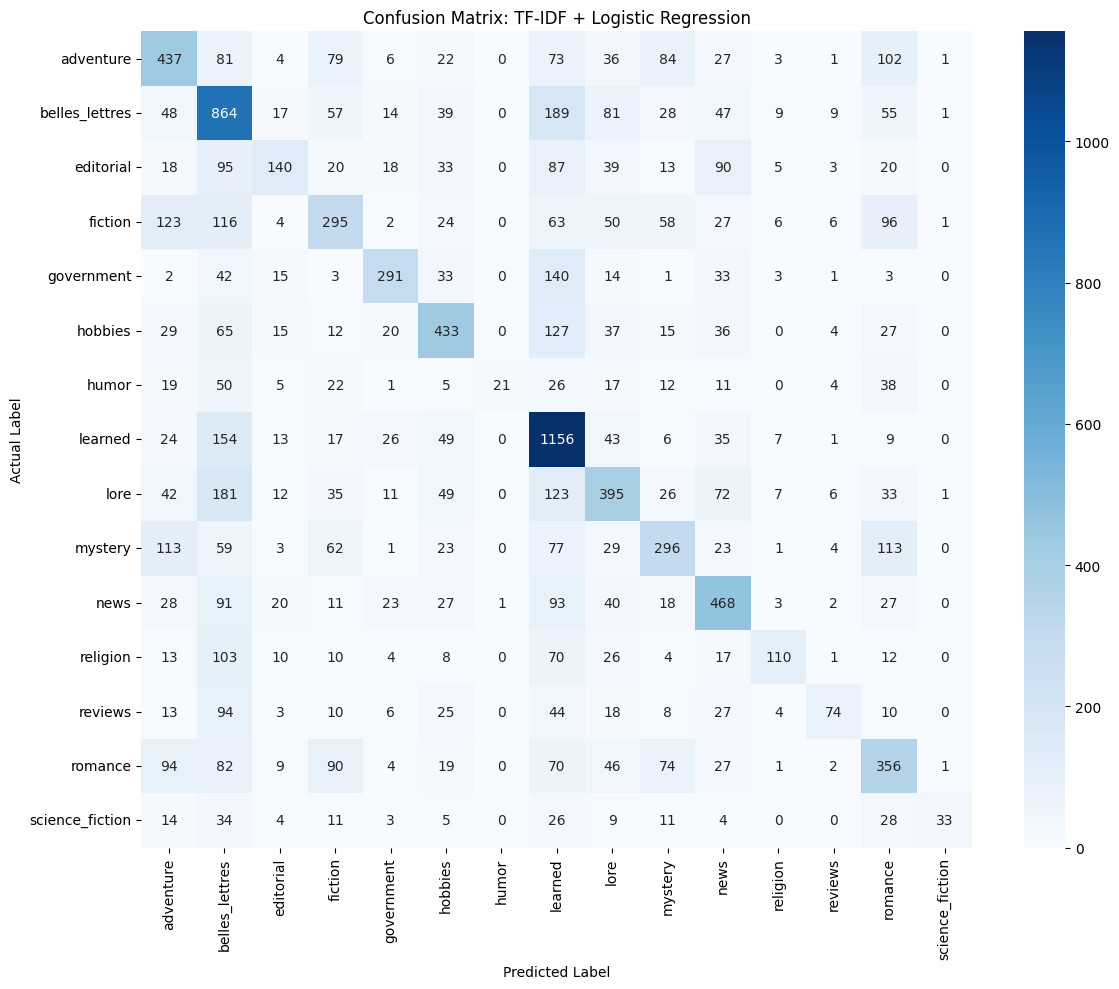


Step 3: Training Model 2 (BERT Embeddings + Logistic Regression)...
Using device: cuda
Generating BERT embeddings for the dataset (this may take a while)...
Training the logistic regression classifier on BERT embeddings...
Evaluating the model...

--- BERT Embeddings Model Results ---
{'adventure': {'precision': 0.3955431754874652, 'recall': 0.4456066945606695, 'f1-score': 0.4190850959173635, 'support': 956.0}, 'belles_lettres': {'precision': 0.4410927717700626, 'recall': 0.5315500685871056, 'f1-score': 0.4821150855365474, 'support': 1458.0}, 'editorial': {'precision': 0.34557235421166305, 'recall': 0.27538726333907054, 'f1-score': 0.3065134099616858, 'support': 581.0}, 'fiction': {'precision': 0.3263598326359833, 'recall': 0.26865671641791045, 'f1-score': 0.2947103274559194, 'support': 871.0}, 'government': {'precision': 0.5876106194690266, 'recall': 0.5714285714285714, 'f1-score': 0.5794066317626527, 'support': 581.0}, 'hobbies': {'precision': 0.6, 'recall': 0.5670731707317073, 'f1-

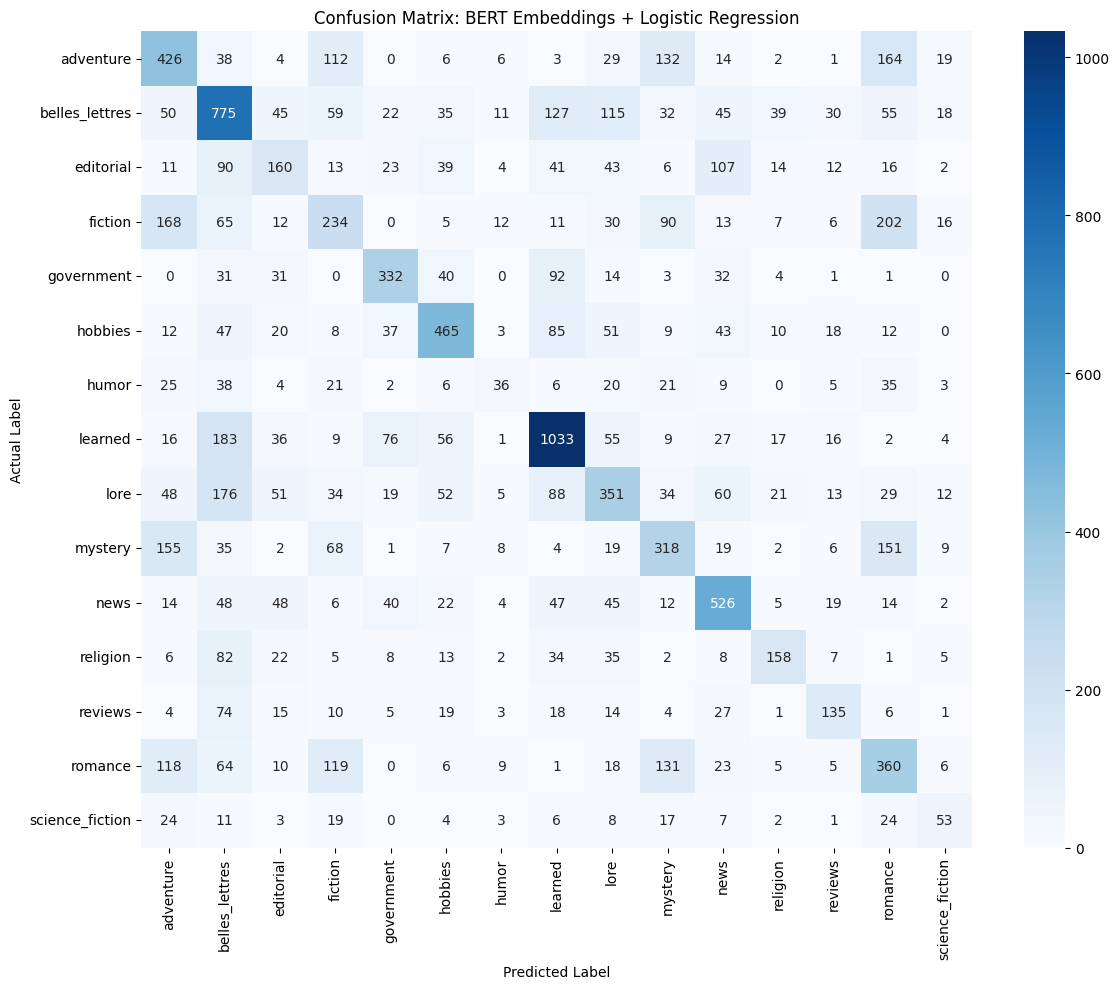


Comparison complete. Check the console for reports and plots for visualizations.


In [7]:
datasets, categories = load_and_prepare_data()

if datasets:
    # # --- Display Class Sizes and Generate LaTeX Table ---
    # print("\n--- LaTeX Code for Genre Distribution Table ---")
    
    # # 1. Get counts and total size
    # all_labels = list(datasets['train']['label']) + list(datasets['test']['label'])
    # label_counts = Counter(all_labels)
    # total_size = len(all_labels)
    
    # # 2. Build the LaTeX table string
    # latex_output = []
    # latex_output.append("\\begin{table}[h!]")
    # latex_output.append("\\centering")
    # latex_output.append("\\caption{Distribution of Genres in the Brown Corpus Dataset}")
    # latex_output.append("\\label{tab:genre-dist}")
    # latex_output.append("\\begin{tabular}{lrr}")
    # latex_output.append("\\hline")
    # latex_output.append("\\textbf{Genre} & \\textbf{Count} & \\textbf{Percentage} \\\\")
    # latex_output.append("\\hline")

    # # 3. Add a row for each category
    # for i, category in enumerate(categories):
    #     count = label_counts[i]
    #     percentage = (count / total_size) * 100
    #     # Escape underscores for LaTeX
    #     safe_category_name = category.replace('_', '\\_')
    #     latex_output.append(f"{safe_category_name} & {count} & {percentage:.2f}\\% \\\\")

    # # 4. Add total row and finish table
    # latex_output.append("\\hline")
    # latex_output.append(f"\\textbf{{Total}} & \\textbf{{{total_size}}} & \\textbf{{100.00\\%}} \\\\")
    # latex_output.append("\\hline")
    # latex_output.append("\\end{tabular}")
    # latex_output.append("\\end{table}")
    
    # # 5. Print the final string
    # print("\n".join(latex_output))

    # --- Run Models ---
    # Step 2: Run TF-IDF Model
    cm_tfidf, cr_tfidf = train_tfidf_model(datasets, categories)
    plot_confusion_matrix(cm_tfidf, categories, 'Confusion Matrix: TF-IDF + Logistic Regression')
    
    # Step 3: Run BERT Embedding Model
    cm_bert, cr_bert = train_bert_embedding_model(datasets, categories)
    plot_confusion_matrix(cm_bert, categories, 'Confusion Matrix: BERT Embeddings + Logistic Regression')

    print("\nComparison complete. Check the console for reports and plots for visualizations.")

In [8]:
import numpy as np
from sklearn.metrics import classification_report

def classification_report_to_latex(report_dict, caption='Classification Report', label='tab:class_report'):
    """
    Generates a LaTeX table from a scikit-learn classification report dictionary.

    Args:
        report_dict (dict): A classification report dictionary as generated by
                            `sklearn.metrics.classification_report(..., output_dict=True)`.
        caption (str): The caption for the LaTeX table.
        label (str): The label for referencing the table in LaTeX.

    Returns:
        str: A string containing the LaTeX code for the table.
    """
    # Check if the input is a dictionary
    if not isinstance(report_dict, dict):
        raise TypeError("Input 'report_dict' must be a dictionary. "
                        "Please generate it using classification_report(..., output_dict=True)")

    # Extract class names and summary keys
    summary_keys = ['accuracy', 'macro avg', 'weighted avg']
    class_names = [key for key in report_dict.keys() if key not in summary_keys]

    # Start building the LaTeX table string
    latex_string = f"\\begin{{table}}[h!]\n"
    latex_string += f"\\centering\n"
    latex_string += f"\\caption{{{caption}}}\n"
    latex_string += f"\\label{{{label}}}\n"
    latex_string += f"\\begin{{tabular}}{{lrrrr}}\n"
    latex_string += f"\\toprule\n"
    latex_string += f"& \\textbf{{Precision}} & \\textbf{{Recall}} & \\textbf{{F1-Score}} & \\textbf{{Support}} \\\\\n"
    latex_string += f"\\midrule\n"

    # Add a row for each class
    for class_name in class_names:
        # Escape underscores for LaTeX
        safe_class_name = class_name.replace('_', '\\_')
        
        metrics = report_dict[class_name]
        precision = f"{metrics['precision']:.2f}"
        recall = f"{metrics['recall']:.2f}"
        f1_score = f"{metrics['f1-score']:.2f}"
        support = f"{int(metrics['support'])}"
        
        latex_string += f"\\textbf{{{safe_class_name}}} & {precision} & {recall} & {f1_score} & {support} \\\\\n"

    latex_string += f"\\midrule\n"
    
    # --- Summary Rows ---
    # Get total support from the 'macro avg' row for consistency
    total_support = int(report_dict['macro avg']['support'])

    # Add accuracy row (if it exists)
    if 'accuracy' in report_dict:
        accuracy = report_dict['accuracy']
        latex_string += f"\\textbf{{Accuracy}} & & & {accuracy:.2f} & {total_support} \\\\\n"

    # Add macro average row
    macro_avg = report_dict['macro avg']
    macro_precision = f"{macro_avg['precision']:.2f}"
    macro_recall = f"{macro_avg['recall']:.2f}"
    macro_f1 = f"{macro_avg['f1-score']:.2f}"
    latex_string += f"\\textbf{{Macro Avg}} & {macro_precision} & {macro_recall} & {macro_f1} & {total_support} \\\\\n"
    
    # Add weighted average row
    weighted_avg = report_dict['weighted avg']
    weighted_precision = f"{weighted_avg['precision']:.2f}"
    weighted_recall = f"{weighted_avg['recall']:.2f}"
    weighted_f1 = f"{weighted_avg['f1-score']:.2f}"
    latex_string += f"\\textbf{{Weighted Avg}} & {weighted_precision} & {weighted_recall} & {weighted_f1} & {total_support} \\\\\n"

    # End the table
    latex_string += f"\\bottomrule\n"
    latex_string += f"\\end{{tabular}}\n"
    latex_string += f"\\end{{table}}\n"
    
    return latex_string

In [9]:
print(classification_report_to_latex(cr_tfidf))
print(classification_report_to_latex(cr_bert))

\begin{table}[h!]
\centering
\caption{Classification Report}
\label{tab:class_report}
\begin{tabular}{lrrrr}
\toprule
& \textbf{Precision} & \textbf{Recall} & \textbf{F1-Score} & \textbf{Support} \\
\midrule
\textbf{adventure} & 0.43 & 0.46 & 0.44 & 956 \\
\textbf{belles\_lettres} & 0.41 & 0.59 & 0.48 & 1458 \\
\textbf{editorial} & 0.51 & 0.24 & 0.33 & 581 \\
\textbf{fiction} & 0.40 & 0.34 & 0.37 & 871 \\
\textbf{government} & 0.68 & 0.50 & 0.58 & 581 \\
\textbf{hobbies} & 0.55 & 0.53 & 0.54 & 820 \\
\textbf{humor} & 0.95 & 0.09 & 0.17 & 231 \\
\textbf{learned} & 0.49 & 0.75 & 0.59 & 1540 \\
\textbf{lore} & 0.45 & 0.40 & 0.42 & 993 \\
\textbf{mystery} & 0.45 & 0.37 & 0.41 & 804 \\
\textbf{news} & 0.50 & 0.55 & 0.52 & 852 \\
\textbf{religion} & 0.69 & 0.28 & 0.40 & 388 \\
\textbf{reviews} & 0.63 & 0.22 & 0.33 & 336 \\
\textbf{romance} & 0.38 & 0.41 & 0.39 & 875 \\
\textbf{science\_fiction} & 0.87 & 0.18 & 0.30 & 182 \\
\midrule
\textbf{Accuracy} & & & 0.47 & 11468 \\
\textbf{Macro Avg} 

In [ ]:
print(classification_report_to_latex(cr_tfidf))
print(classification_report_to_latex(cr_bert))

\begin{table}[h!]
\centering
\caption{Classification Report}
\label{tab:class_report}
\begin{tabular}{lrrrr}
\toprule
& \textbf{Precision} & \textbf{Recall} & \textbf{F1-Score} & \textbf{Support} \\
\midrule
\textbf{adventure} & 0.43 & 0.46 & 0.44 & 956 \\
\textbf{belles\_lettres} & 0.41 & 0.59 & 0.48 & 1458 \\
\textbf{editorial} & 0.51 & 0.24 & 0.33 & 581 \\
\textbf{fiction} & 0.40 & 0.34 & 0.37 & 871 \\
\textbf{government} & 0.68 & 0.50 & 0.58 & 581 \\
\textbf{hobbies} & 0.55 & 0.53 & 0.54 & 820 \\
\textbf{humor} & 0.95 & 0.09 & 0.17 & 231 \\
\textbf{learned} & 0.49 & 0.75 & 0.59 & 1540 \\
\textbf{lore} & 0.45 & 0.40 & 0.42 & 993 \\
\textbf{mystery} & 0.45 & 0.37 & 0.41 & 804 \\
\textbf{news} & 0.50 & 0.55 & 0.52 & 852 \\
\textbf{religion} & 0.69 & 0.28 & 0.40 & 388 \\
\textbf{reviews} & 0.63 & 0.22 & 0.33 & 336 \\
\textbf{romance} & 0.38 & 0.41 & 0.39 & 875 \\
\textbf{science\_fiction} & 0.87 & 0.18 & 0.30 & 182 \\
\midrule
\textbf{Accuracy} & & & 0.47 & 11468 \\
\textbf{Macro Avg} 